## Classification with Python

Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling. 

This next homework will test your classification abilities. We will be trying to predict whether a person survived the Titantic:

https://www.kaggle.com/c/titanic

The evalution metric for Kaggle is accuracy, but please also explore how well your model does on multiple metrics like F1, precision, recall, and area under the ROC curve.

### Grading

This homework is due **March 8, 2018 by midnight Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [74]:
import pandas as pd
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
%matplotlib inline

### Reading in the Data
- First I will read in test and train data
- Next I will append the two data sets
- This way, both data sets are cleaned up in the same way
- later to train a mode, i will seperate the training data
- I will then construct training sets within the training data to actually train a model

In [75]:
test = pd.read_csv('test_titanic.csv')

In [76]:
train = pd.read_csv('train_titanic.csv')

In [77]:
dat = train.append(test).reset_index(drop=True)

In [78]:
dat.head(3)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282


### Summary Statistics of Variables

In [79]:
dat.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


In [80]:
dat.columns = dat.columns.str.lower()
train.columns=train.columns.str.lower()

### We can plot out the missing values in our training data

In [81]:
null_percent = dat.isnull().sum().to_frame()/(dat.index.max()+1)
null_percent.columns=['percent']
null_percent = null_percent.query('percent > 0')

Text(0,0.5,'Percent')

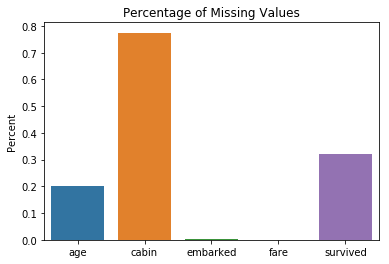

In [82]:
ax = sns.barplot(data=null_percent.transpose())
ax.set_title('Percentage of Missing Values')
ax.set_ylabel('Percent')

### Handling Missing Values
- First, The fact that no cabin is reported for many passengers may be a sign of how the ship valued that passenger
- I created a no_cabin variable to capture this. 
- I did the sae with people who did not have an age reported
- One observation had no fare listed, I replaced it with zero
- A few had missing embarkation, I created a new category called "none"

In [83]:
dat['no_cabin'] = dat.eval('cabin!=cabin').astype(int)

In [84]:
dat['no_age'] = dat.eval('age!=age').astype(int)
dat['age'] = dat['age'].fillna(value=0)

In [85]:
dat['embarked']=dat['embarked'].fillna(value='none')
dat['fare']=dat['fare'].fillna(value=0)

### Some Data Visualization
- We will look at survival rates by a few different variables
- First survival by class and gender
- Next we will look at if a cabin number was recorded
- Then we will look at the cabin block and also gender

Text(0.5,1,'Survivors by Gender and Ticket Class')

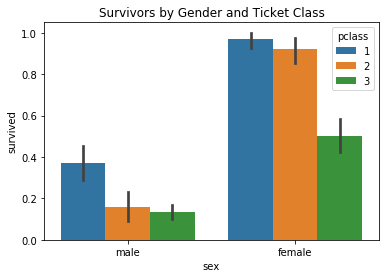

In [86]:
x = dat.query('survived==survived')
ax = sns.barplot(x="sex", y="survived", hue="pclass", data=x)
ax.set_title('Survivors by Gender and Ticket Class')

#### Further Examination of Cabin
I'm not really sure about the cabin numbers. Remember that over 70% of passengers had missing values for cabin. Maybe the Cabin letter makes a difference. For example, maybe being in cabin A11 is better than F11, or perhaps F11 is better than A11 as far as access to life boats, etc. I will create the cab_letter variable by pulling out the first character from Cabin. 

In [87]:
dat['cab_letter'] = dat.cabin.str[0]

#### Plotting having a cabin number assigned and survival
- Indeed we see that those passengers who had a cabin recorded in the data had a much higher likelihood of survival

Text(0.5,1,'Survival Based on if a Cabin was listed 1=no cabin, 0 = cabin listed')

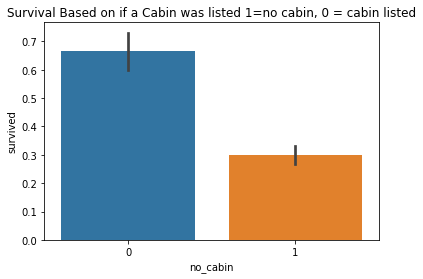

In [88]:
x = dat.query('survived == survived')
ax = sns.barplot(x="no_cabin", y="survived", data=x)
ax.set_title('Survival Based on if a Cabin was listed 1=no cabin, 0 = cabin listed')

#### Now we will consider the first letter of the cabin and survival
- notice some seem to be a little better than others, but there aren't huge differences
- It seems like maybe E, D, and B would be a little better

Text(0.5,1,'Survival by cabin letter')

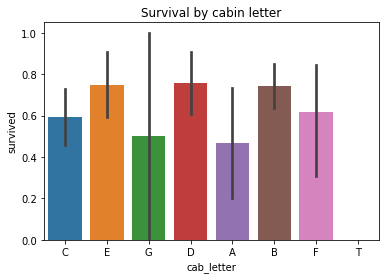

In [89]:
ax = sns.barplot(x="cab_letter", y="survived", data=x)
ax.set_title('Survival by cabin letter')

#### Cabin Letter and Gender
- Here we see that Females in every cabin block except G had almost 100 percent chance of survival
- Lets further examine block G

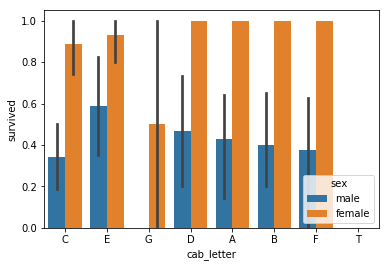

In [90]:
ax = sns.barplot(x="cab_letter", y="survived",hue='sex', data=x)


#### Survival Percentage of Females with recorded cabins, with Males in the cabin block
- We see this is a very high rate of survival for 93 females

In [91]:
cab_female = x.query("(cab_letter == 'C' | cab_letter == 'E' | cab_letter == 'D' | cab_letter == 'A' | cab_letter == 'B' | cab_letter == 'F') & sex=='female'" )
tot = cab_female['passengerid'].count()
surv = cab_female['survived'].sum()
print("Number of Females: {}".format(tot))
print("Survival Rate: {}".format(surv/tot))

Number of Females: 93
Survival Rate: 0.956989247311828


### Looking at the Data More Broadly
- We've dug deep into a few aspects of the data. Lets look at the bigger picture
- First, I will create dummies for gender and embarkation
- Next I will create a heatmap to visualize correlations with survival
- Then we will have clean data that we have visualized. The next step will be to begin modeling. 

In [92]:
del dat['name']

In [93]:
dat.columns

Index(['age', 'cabin', 'embarked', 'fare', 'parch', 'passengerid', 'pclass',
       'sex', 'sibsp', 'survived', 'ticket', 'no_cabin', 'no_age',
       'cab_letter'],
      dtype='object')

In [94]:
dat = pd.get_dummies(dat[['passengerid','survived','pclass','sex','age','sibsp','parch','fare','embarked','no_cabin','no_age','cab_letter']])

In [95]:
dat.head(3)

,passengerid,survived,pclass,age,sibsp,parch,fare,no_cabin,no_age,sex_female,...,embarked_S,embarked_none,cab_letter_A,cab_letter_B,cab_letter_C,cab_letter_D,cab_letter_E,cab_letter_F,cab_letter_G,cab_letter_T
0,1,0.0,3,22.0,1,0,7.2500,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,1.0,1,38.0,1,0,71.2833,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,3,1.0,3,26.0,0,0,7.9250,1,0,1,...,1,0,0,0,0,0,0,0,0,0


##### Below we have a heatmap of absolute value correlations. We see that gender, not having a cabin, and pclass all have a decent correlation with survival

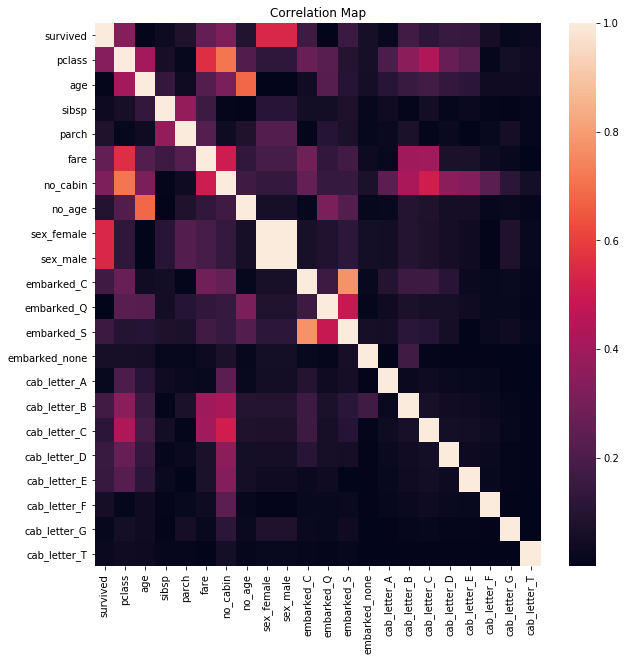

In [96]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Correlation Map')
heat = dat.copy()
del heat['passengerid']
sns.heatmap(np.abs(heat.corr()), ax=ax )
del heat

### Now We Are Ready for the Fun Part!
- Modeling

### Model 1: Linear Probability Model
##### Description: 
- We simply run a regression of all of our variables on survival
- We can then predict values for survival for test data (predictions will mostly be between 0 and 1)
- We assign anything over .5 to be a 1 and anything below .5 to 0
##### Pros:
- Very simple and understandable
- Computationally easy (we can just do least squares regression, not really any hyper parameters, etc.)
##### Cons:
- Sometimes gives values outside of the interval 0 to 1, which we can't interpret correctly as probabilities
- So simple it might miss a lot (high MSE)
##### Assumptions:
- Classic OLS Assumptions (no multicolinearity, no heteroskedasticity or autocorrelation, unbiased error term, etc)
##### Method:
- Ordinary Least Squares Regression
- Find regression coefficients for all parameters using all of the available testing data
- Predict Survival for testing data
- Submit to Kaggle and hope for the best :)

In [97]:
train = dat.query('survived==survived')
test = dat.query('survived != survived')
target = train.survived
del train['passengerid']
del train['survived']
del test['survived']
del test['passengerid']

In [98]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(train, target)
survival = regr.predict(test)

In [99]:
results = pd.DataFrame(survival, index=dat.query('survived!=survived')['passengerid'], columns = ['survival']).reset_index()

In [100]:
results['survival'] = results.eval('survival > .5').astype(int)
results.head()

,passengerid,survival
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


##### Results:
- Submitting these results on Kaggle yielded a score of .76
- This isn't a terrible result, but I think we can do a lot better.

### Model 2: Logistic
- Unlike the linear probability model, the logistic regression will return actual probabilities
- It is a slightly more complicated model
- we are assuming a type distribution function (the logistic function) (maximum likelihood estimation)
- we need to choose penalty (l1 or l2)
- More complex, but it will potentially give us better results


In [101]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [102]:
data = dat.query('survived==survived').copy()
target = data.survived
del data['passengerid']
del data['survived']

In [103]:
scaler = StandardScaler()
scaler.fit(data)
scaled_df = scaler.transform(data)
X_train, X_test, y_train, y_test = train_test_split(scaled_df, target, test_size=0.33, random_state=42)

##### Using the L1 norm
- We see that we get pretty good train and test accuracy (compared to linear probability, kaggle accuracy of .76)
- The confusion matrix shows us that we are predicting that alot of people who actually survive won't survive

In [104]:
clf = linear_model.LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

In [105]:
print("Train acc: {}".format(accuracy_score(y_train, train_predictions)))
print("Test acc: {}".format(accuracy_score(y_test, test_predictions)))

Train acc: 0.7986577181208053
Test acc: 0.8


In [106]:
confusion_matrix(y_test, test_predictions)

array([[150,  25],
       [ 34,  86]], dtype=int64)

##### L2 Norm
- Very similar to the L1.
- We essentiall moved one false negative to a false positive
- slightly better accuracy scores

In [107]:
clf = linear_model.LogisticRegression(penalty='l2')
clf.fit(X_train, y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)
print("Train acc: {}".format(accuracy_score(y_train, train_predictions)))
print("Test acc: {}".format(accuracy_score(y_test, test_predictions)))

Train acc: 0.7986577181208053
Test acc: 0.8033898305084746


In [108]:
confusion_matrix(y_test, test_predictions)

array([[151,  24],
       [ 34,  86]], dtype=int64)

##### Fitting the model on the actual test/train data with L2 and submitting to Kaggle
- Scores .751 on Kaggle
- This is a little surprising

In [109]:
clf.fit(data,target)
test = dat.query('survived!=survived').copy()
Passengerid = test.passengerid
del test['passengerid']
del test['survived']
predict = clf.predict(test)
results = pd.DataFrame(predict,index=Passengerid)

In [110]:
results.columns = ['Survived']
results.reset_index().to_csv('logistic_l2_results.csv',index=False)


##### Let's take a look at optimal cutoff values

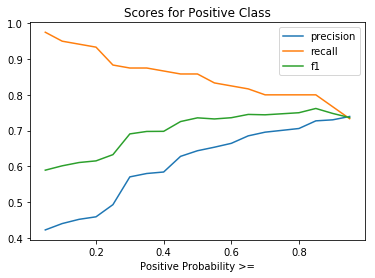

In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_recall_fscore_support


train_prediction_probabilities = clf.predict_proba(X_train)
test_prediction_probabilities = clf.predict_proba(X_test)
precisions, recalls, f1s = [], [], []
cutoffs = np.arange(0.05, 1, 0.05)
for cutoff in cutoffs:
    binary_test_predictions = [x[1] >= cutoff for x in test_prediction_probabilities]
    p, r, f1, s = precision_recall_fscore_support(y_test, binary_test_predictions)
    precisions.append(p[1])
    recalls.append(r[1])
    f1s.append(f1[1])
    
plt.plot(cutoffs, precisions, label='precision')
plt.plot(cutoffs, recalls, label='recall')
plt.plot(cutoffs, f1s, label='f1')
plt.xlabel("Positive Probability >=")
plt.title("Scores for Positive Class")
plt.legend()

##### We see that the optimal cutoff for f1 is at .85. This doesn't seem like it will deliver very good precision or recall though

In [112]:
cutoffs[np.argmax(f1s)]

0.85000000000000009

### Model 3: K-Nearest Neighbors

##### Method:
- Classify test points based on distance (by some norm) from different classes
##### Benefits:
- It makes sense
- Intuitive
- Doesn't rely on very restrictive assumptions (like OLS)
##### Drawbacks:
- Difficult to find seperating hyperplanes in high dimensions
- Have to select hyperparameters (k, as well as which norm to use). 
- Doesn't provide intuition with feature selection
##### Primary Assumption:
- If an observation is 'nearer' to one class than another, then it probably belongs to that class
- Honestly, I don't even know how you could form a classification model if you didn't believe an assumption like this. 

In [113]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error

In [114]:
#we already have x_train, y_train, etc from previous models. 

In [115]:
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 7, 'weights': 'uniform', 'p': 1}
Train F1: 0.7780548628428928
Test Classification Report:
             precision    recall  f1-score   support

        0.0       0.80      0.86      0.83       175
        1.0       0.77      0.68      0.72       120

avg / total       0.79      0.79      0.78       295

Train Accuracy: 0.8506711409395973	Test accuracy: 0.7864406779661017


In [116]:
clf = KNeighborsClassifier(n_neighbors = 7, p=1,weights = 'uniform')

clf.fit(data,target)
test = dat.query('survived!=survived').copy()
Passengerid = test.passengerid
del test['passengerid']
del test['survived']
predict = clf.predict(test)
results = pd.DataFrame(predict,index=Passengerid)

In [117]:
results = results.reset_index()
results.columns = ['Passengerid','Survived']
results.to_csv('k_nearest_results.csv',index=False)

In [118]:
x = results.copy()

In [119]:
test = dat.query('survived!=survived').copy()


In [120]:
x.describe()

,Passengerid,Survived
count,418.000000,418.000000
mean,1100.500000,0.344498
std,120.810458,0.475774
min,892.000000,0.000000
25%,996.250000,0.000000
50%,1100.500000,0.000000
75%,1204.750000,1.000000
max,1309.000000,1.000000


In [121]:
results.head()

,Passengerid,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


### Model 4: Random Forest
##### Method: 
- We are essentially repeating non-correlated decision trees to find which features matter most
##### Pros:
- Very Powerful
##### Cons:
- Not as easy to understand
- We need hyperparameters!

In [122]:
from sklearn.ensemble import RandomForestClassifier


In [123]:
n_estimators = [1000, 2500, 5000]
max_depth = [1, 3, 5, 10]
class_weights = ['balanced', None]
best_f1 = 0

for est in n_estimators:
    for depth in max_depth:
        for wgt in class_weights:
            print(est, depth, wgt)
            clf = RandomForestClassifier(n_estimators=est, max_depth=depth, oob_score=True, class_weight=wgt)
            clf.fit(data, target)
            f1 = f1_score(target, np.argmax(clf.oob_decision_function_ , 1))
            if f1 > best_f1:
                best_f1 = f1
                best_params = (est, depth, wgt)

1000 1 balanced
1000 1 None
1000 3 balanced
1000 3 None
1000 5 balanced
1000 5 None
1000 10 balanced
1000 10 None
2500 1 balanced
2500 1 None
2500 3 balanced
2500 3 None
2500 5 balanced
2500 5 None
2500 10 balanced
2500 10 None
5000 1 balanced
5000 1 None
5000 3 balanced
5000 3 None
5000 5 balanced
5000 5 None
5000 10 balanced
5000 10 None


In [124]:
print("Best OOB F1: {}".format(best_f1))
print("Best params: {}".format(best_params))

Best OOB F1: 0.7435508345978755
Best params: (1000, 10, 'balanced')


In [125]:
clf = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1], class_weight=best_params[2])
clf.fit(data, target)



RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [126]:
test = dat.query('survived!=survived').copy()
del test['passengerid']
del test['survived']
test_predictions = clf.predict(test)

In [127]:
index = test.index + 1
results = pd.DataFrame(test_predictions,index=index)
results = results.reset_index()
results.columns = ['Passengerid','Survived']
results.to_csv('random_forest_results.csv',index=False)

In [128]:
feature_imp = sorted(list(zip(data.columns, clf.feature_importances_)), key=lambda x: x[1], reverse=True)

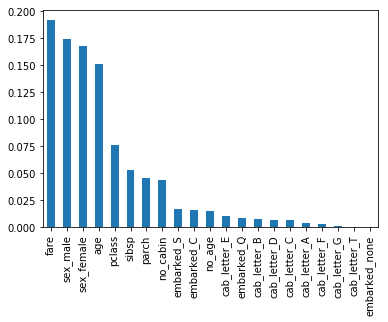

In [129]:
pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp]).plot(kind='bar')

### Final Look
- Random Forest above did pretty well, but actually only slightly slightly better than Linear Probability model on Kaggle. 
- We have our feature importances above.
- Lets take fare, sex_male, age, pclass, and then combine sibsp and parch and try k-nearest again. 

In [133]:
data = data[['fare','sex_male','age','pclass','sibsp','parch']]
test = test[['fare','sex_male','age','pclass','sibsp','parch']]

data['fam'] = data['sibsp']+data['parch']
test['fam'] = test['sibsp']+test['parch']

data = data.drop(['sibsp','parch'],axis=1)
test = test.drop(['sibsp','parch'],axis=1)

C:\Users\jonathanjensen\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [134]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=42)
clf = KNeighborsClassifier()
gridsearch = GridSearchCV(clf, {"n_neighbors": [1, 3, 5, 7, 9, 11], "weights": ['uniform', 'distance'], 
                                'p': [1, 2, 3]}, scoring='f1')
gridsearch.fit(X_train, y_train)
print("Best Params: {}".format(gridsearch.best_params_))
y_pred_train = gridsearch.predict(X_train)
print("Train F1: {}".format(f1_score(y_train, y_pred_train)))
print("Test Classification Report:")
y_pred_test = gridsearch.predict(X_test)
print(classification_report(y_test, y_pred_test))
print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

Best Params: {'n_neighbors': 11, 'weights': 'distance', 'p': 1}
Train F1: 0.9723502304147464
Test Classification Report:
             precision    recall  f1-score   support

        0.0       0.74      0.83      0.78       175
        1.0       0.69      0.57      0.62       120

avg / total       0.72      0.72      0.72       295

Train Accuracy: 0.9798657718120806	Test accuracy: 0.7220338983050848


In [136]:
clf = KNeighborsClassifier(n_neighbors = 11, p=1,weights = 'distance')
clf.fit(data,target)

predict = clf.predict(test)
results = pd.DataFrame(predict,index=Passengerid)

In [138]:
results.to_csv('kn_final.csv')

#### Results
- K-nearest did pretty bad on kaggle, both times.
- Random Forest was pretty good, but not much better than Linear Probability model
- In this case, the simplest is maybe the best. 